<a href="https://colab.research.google.com/github/sagar282004/Battery-Management-System-to-Estimate-the-SOC-of-an-EV-Cell/blob/main/BMS_SOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
fresh_df = pd.read_csv('Experimental_data_fresh_cell.csv')
aged_df = pd.read_csv('Experimental_data_aged_cell.csv')
print(fresh_df.head())
print(aged_df.head())


       Time   Current   Voltage  Temperature
0  0.000000  2.158704  2.999607    26.384377
1  1.000000  2.287674  2.999407    26.227879
2  2.000000  2.228280  2.999757    26.449251
3  2.999992  2.224886  2.999857    26.277494
4  4.000000  2.134946  2.999958    26.380539
       Time   Current   Voltage  Temperature
0  0.000000  2.360728  2.999311    27.449894
1  1.000008  2.303036  2.999813    27.724861
2  2.000008  2.284371  2.999863    27.545357
3  3.000008  2.221588  2.999863    27.457523
4  4.000008  2.158805  2.999813    27.484249


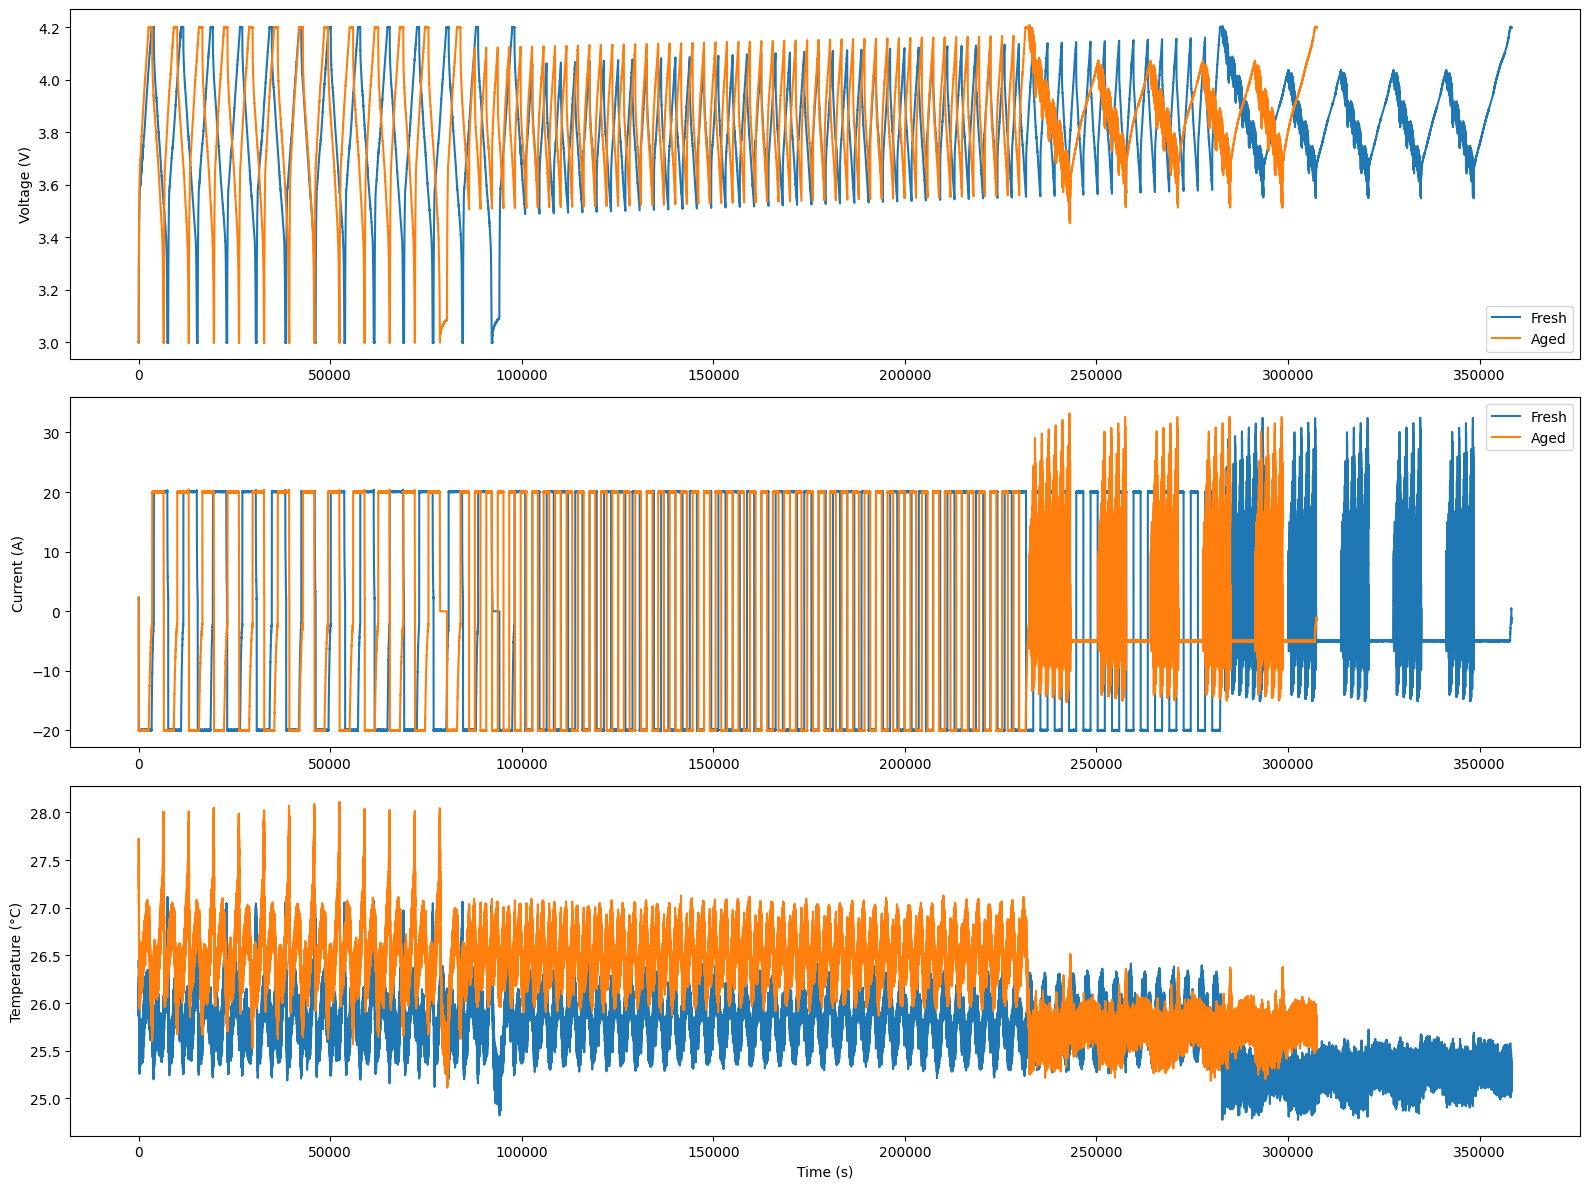

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
ax[0].plot(fresh_df['Time'], fresh_df['Voltage'], label='Fresh')
ax[0].plot(aged_df['Time'], aged_df['Voltage'], label='Aged')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()
ax[1].plot(fresh_df['Time'], fresh_df['Current'], label='Fresh')
ax[1].plot(aged_df['Time'], aged_df['Current'], label='Aged')
ax[1].set_ylabel('Current (A)')
ax[1].legend()
ax[2].plot(fresh_df['Time'], fresh_df['Temperature'], label='Fresh')
ax[2].plot(aged_df['Time'], aged_df['Temperature'], label='Aged')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


In [8]:
# Internal resistance estimation (smoothing built-in)
def estimate_internal_resistance_improved(df, window_length=5, polyorder=2):
    voltage_smooth = savgol_filter(df['Voltage'], window_length, polyorder)
    current_smooth = savgol_filter(df['Current'], window_length, polyorder)
    dV = np.diff(voltage_smooth)
    dI = np.diff(current_smooth)
    with np.errstate(divide='ignore', invalid='ignore'):
        r_internal = dV / dI
        valid_mask = (np.isfinite(r_internal) & (r_internal > 0) & (r_internal < 1.0) & (np.abs(dI) > 0.01))
        r_internal_filtered = np.full(len(df), np.nan)
        r_internal_filtered[1:][valid_mask] = r_internal[valid_mask]
        r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')
        r_internal_smooth = gaussian_filter1d(r_internal_clean, sigma=1.0)
    return r_internal_smooth

fresh_df['internal_resistance'] = estimate_internal_resistance_improved(fresh_df)
aged_df['internal_resistance'] = estimate_internal_resistance_improved(aged_df)


/tmp/ipython-input-2238478371.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-2238478371.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')


In [9]:
mean_fresh_r = fresh_df['internal_resistance'].mean()
# SOH proxy: 1.0 for fresh, aged as ratio of fresh IR to sample IR
fresh_df['SOH'] = 1.0
aged_df['SOH'] = (mean_fresh_r / aged_df['internal_resistance']).clip(0, 1)
full_df = pd.concat([fresh_df, aged_df], ignore_index=True)


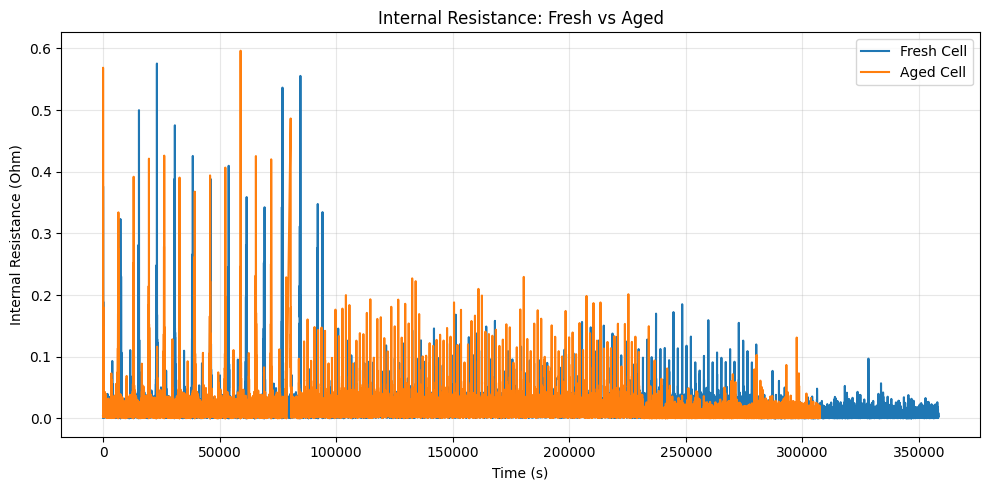

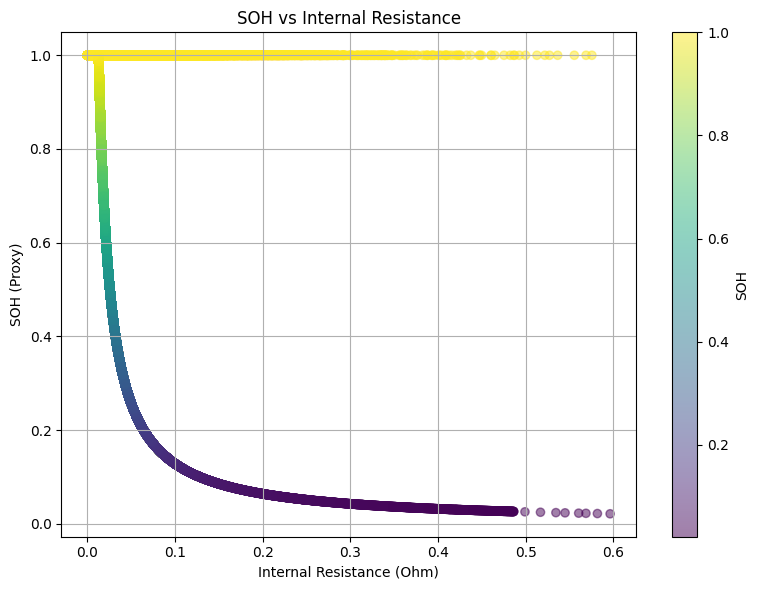

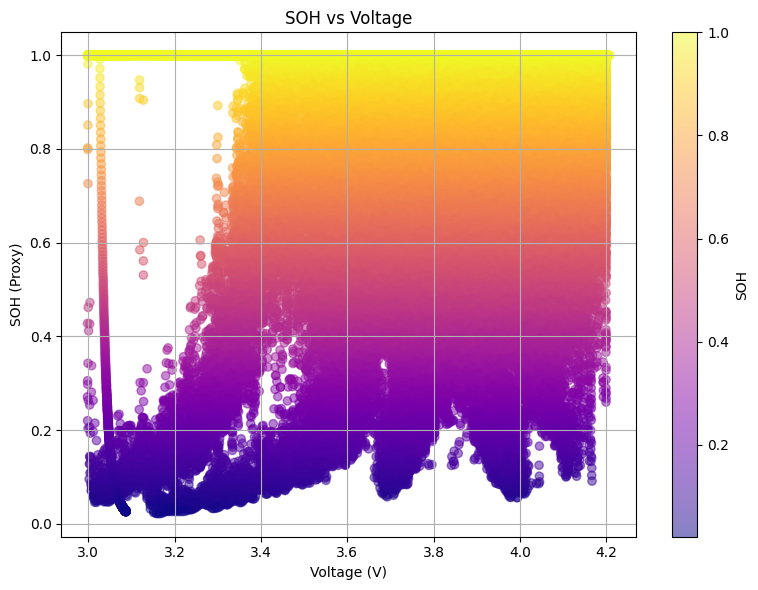

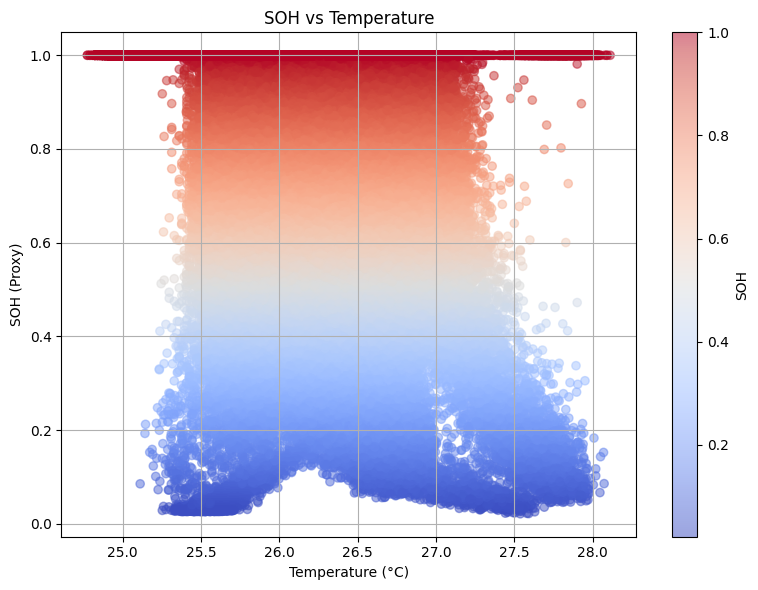

In [10]:
# Internal Resistance vs Time
plt.figure(figsize=(10,5))
plt.plot(fresh_df['Time'], fresh_df['internal_resistance'], label='Fresh Cell')
plt.plot(aged_df['Time'], aged_df['internal_resistance'], label='Aged Cell')
plt.xlabel('Time (s)')
plt.ylabel('Internal Resistance (Ohm)')
plt.title('Internal Resistance: Fresh vs Aged')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SOH vs Internal Resistance scatter
plt.figure(figsize=(8,6))
plt.scatter(full_df['internal_resistance'], full_df['SOH'], c=full_df['SOH'], cmap='viridis', alpha=0.5)
plt.xlabel('Internal Resistance (Ohm)')
plt.ylabel('SOH (Proxy)')
plt.title('SOH vs Internal Resistance')
plt.colorbar(label='SOH')
plt.grid(True)
plt.tight_layout()
plt.show()

# SOH vs Voltage
plt.figure(figsize=(8,6))
plt.scatter(full_df['Voltage'], full_df['SOH'], c=full_df['SOH'], cmap='plasma', alpha=0.5)
plt.xlabel('Voltage (V)')
plt.ylabel('SOH (Proxy)')
plt.title('SOH vs Voltage')
plt.colorbar(label='SOH')
plt.grid(True)
plt.tight_layout()
plt.show()

# SOH vs Temperature
plt.figure(figsize=(8,6))
plt.scatter(full_df['Temperature'], full_df['SOH'], c=full_df['SOH'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('SOH (Proxy)')
plt.title('SOH vs Temperature')
plt.colorbar(label='SOH')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
full_df['voltage_derivative'] = np.gradient(full_df['Voltage'], full_df['Time'])
full_df['voltage_derivative_smooth'] = savgol_filter(full_df['voltage_derivative'], 5, 2)
full_df['current_derivative'] = np.gradient(full_df['Current'], full_df['Time'])
full_df['current_derivative_smooth'] = savgol_filter(full_df['current_derivative'], 5, 2)
full_df['temperature_gradient'] = np.gradient(full_df['Temperature'], full_df['Time'])
full_df['temperature_gradient_smooth'] = savgol_filter(full_df['temperature_gradient'], 5, 2)
full_df['power'] = full_df['Voltage'] * full_df['Current']
full_df['power_smooth'] = savgol_filter(full_df['power'], 5, 2)
full_df['voltage_current_ratio'] = full_df['Voltage'] / (np.abs(full_df['Current']) + 0.001)
window = 10
full_df['voltage_ma'] = full_df['Voltage'].rolling(window=window, center=True).mean()
full_df['current_ma'] = full_df['Current'].rolling(window=window, center=True).mean()
full_df['temperature_ma'] = full_df['Temperature'].rolling(window=window, center=True).mean()
full_df['voltage_deviation'] = full_df['Voltage'] - full_df['voltage_ma']
full_df['is_discharging'] = (full_df['Current'] < -0.1).astype(int)
full_df['is_charging'] = (full_df['Current'] > 0.1).astype(int)
full_df = full_df.fillna(method='bfill').fillna(method='ffill')


/tmp/ipython-input-4102179252.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = full_df.fillna(method='bfill').fillna(method='ffill')


In [12]:
feature_cols = [
    'Voltage', 'Current', 'Temperature',
    'voltage_derivative_smooth', 'current_derivative_smooth', 'temperature_gradient_smooth',
    'power_smooth', 'voltage_current_ratio', 'voltage_deviation',
    'is_discharging', 'is_charging', 'internal_resistance'
]
target_col = 'SOH'

X = full_df[feature_cols].fillna(full_df[feature_cols].mean())
y = full_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}
for name, model in models.items():
    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        score = model.score(X_test_scaled, y_test)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
    rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} -- R²: {score:.4f}, RMSE: {rmse_val:.4f}")


Random Forest -- R²: 0.9850, RMSE: 0.0206
Gradient Boosting -- R²: 0.9197, RMSE: 0.0477
Linear Regression -- R²: 0.4051, RMSE: 0.1298
Decision Tree -- R²: 0.9717, RMSE: 0.0283


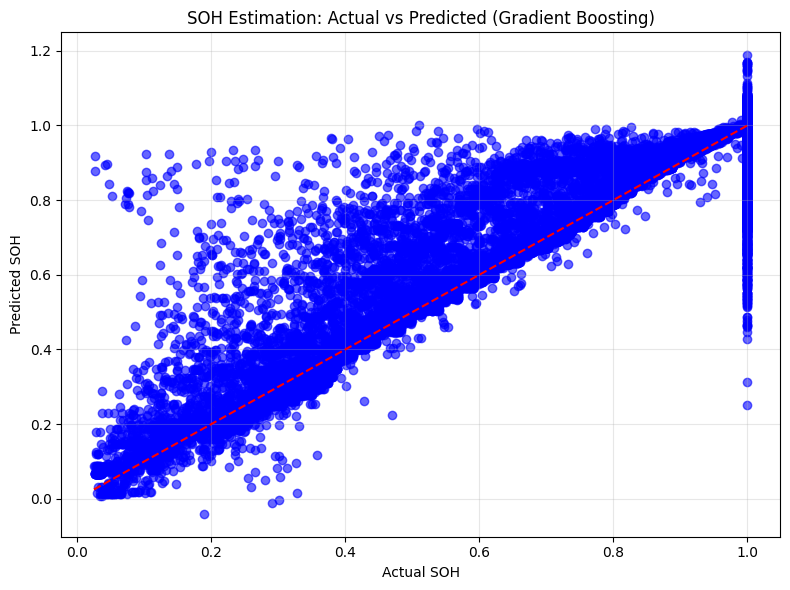

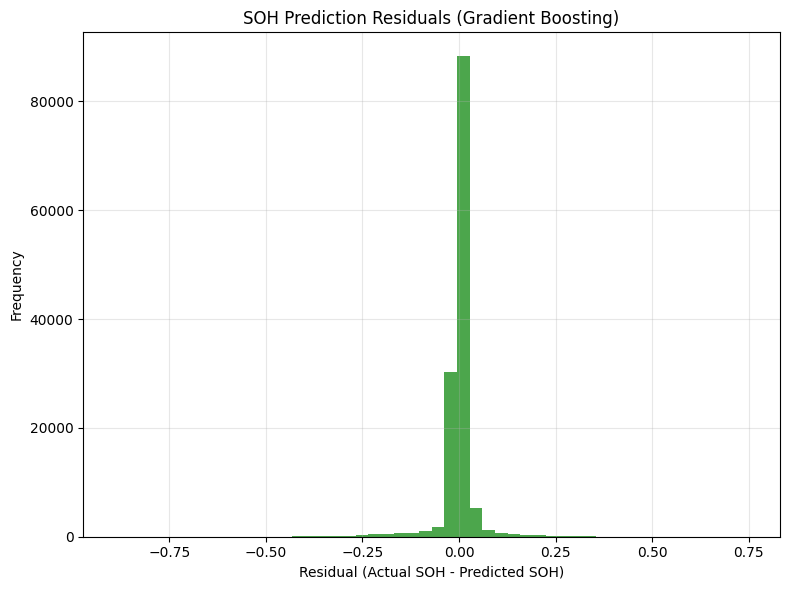

In [14]:
best_model = GradientBoostingRegressor(random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("SOH Estimation: Actual vs Predicted (Gradient Boosting)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, color='green', alpha=0.7)
plt.xlabel("Residual (Actual SOH - Predicted SOH)")
plt.ylabel("Frequency")
plt.title("SOH Prediction Residuals (Gradient Boosting)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


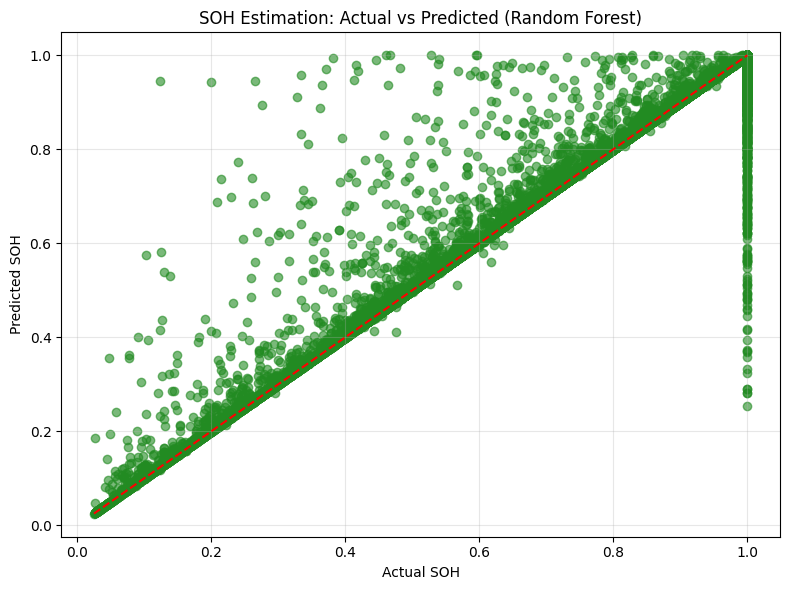

In [16]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("SOH Estimation: Actual vs Predicted (Random Forest)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


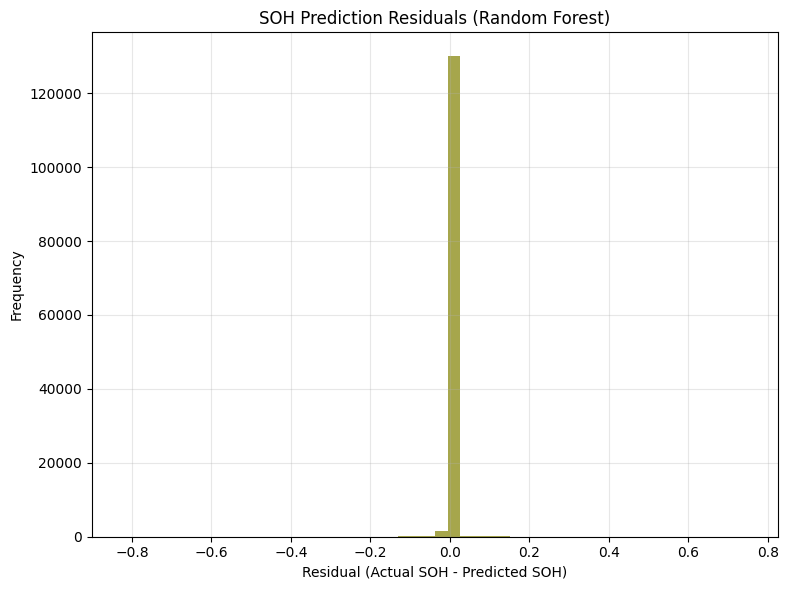

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, color='olive', alpha=0.7)
plt.xlabel("Residual (Actual SOH - Predicted SOH)")
plt.ylabel("Frequency")
plt.title("SOH Prediction Residuals (Random Forest)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


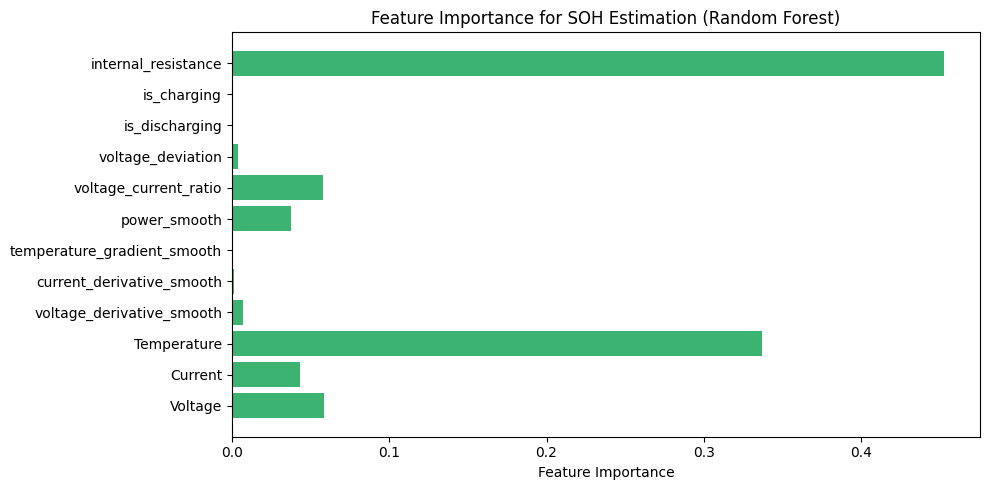

In [19]:
importances = best_model.feature_importances_
plt.figure(figsize=(10,5))
plt.barh(feature_cols, importances, color='mediumseagreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for SOH Estimation (Random Forest)')
plt.tight_layout()
plt.show()
